# Input first 5 paragraphs of news articles into the IST-195 data store

Make sure that: 
* The db, meta-dna, exists in Stardog
* The db, ist-195, does NOT exist
* flask is running (in the dna directory)

In [1]:
import json
import requests

In [2]:
# Create the repository for the news articles
response = requests.post('http://127.0.0.1:5000/dna/v1/repositories?repository=ist-195')
print(response.status_code, response) 
# Verify that the repository was created
response = requests.get('http://127.0.0.1:5000/dna/v1/repositories')
print(response.status_code, response.json()) 

201 <Response [201]>
200 [{'created': '2022-10-03T14:54:07', 'repository': 'ist-195'}]


In [3]:
# Code below simulates getting the meta-data for news using a pre-selected list and news API service
# Or the meta-data may be input manually, or missing altogether except for a title
LC_FarRight_meta = {
            "author": "Jordan Dixon-Hamilton",
            "published": "2022-08-16T00:00:00",
            "publisher": "Breitbart",
            "source": "https://www.breitbart.com/politics/2022/08/16/liz-cheney-compares-herself-abraham-lincoln-concession-speech/",
            "title": "Liz Cheney Compares Herself to Abraham Lincoln in Concession Speech"}
LC_Right_meta = {
            "author": "Brandon Gillespie",
            "published": "2022-08-16T00:00:00",
            "publisher": "Fox News",
            "source": "https://www.foxnews.com/politics/liz-cheney-compares-herself-abraham-lincoln-resounding-defeat-wyoming-primary", 
            "title": "Rep. Liz Cheney compares herself to Abraham Lincoln following resounding defeat in Wyoming primary"}
LC_Center_meta = {
            "author": "Natalie Andrews",
            "published": "2022-08-17T00:00:00",
            "publisher": "Wall Street Journal",
            "source": "https://www.wsj.com/articles/liz-cheney-faces-uphill-fight-in-primary-against-trump-backed-opponent-11660642201", 
            "title": "Liz Cheney Concedes to Trump-Backed Challenger in Wyoming Primary"}
LC_Left_meta = {
            "author": "Maggie Astor",
            "published": "2022-08-17T00:00:00",
            "publisher": "New York Times",
            "source": "https://www.nytimes.com/2022/08/17/us/politics/liz-cheney-concession-speech.html", 
            "title": "Liz Cheney Invokes Lincoln and Grant in Impassioned Concession Speech"}
meta_array = [LC_FarRight_meta, LC_Right_meta, LC_Center_meta, LC_Left_meta]

In [4]:
# Ingest the news articles to the repository
# This code (1) inputs the news article, (2) parses it using the spaCy NLP libraries, 
#   3) creates an intermediary 'dictionary' of the information in the parsed sentences),
#   4) performs coreference analysis and concept mapping to the DNA ontology and
#   5) creation of the knowledge graph
index = 0
for file_name in ('LC-FarRight', 'LC-Right', 'LC-Center', 'LC-Left'):
    with open(f'{file_name}.txt', 'r') as inf:
        news_text = inf.read()    
    req_dict = {"narrativeMetadata" : meta_array[index],
                "narrative": news_text}
    index += 1
    response = requests.post('http://127.0.0.1:5000/dna/v1/repositories/narratives?repository=ist-195&extSources=true',
                             json=req_dict)
    print(response.status_code, response.json())
    print()
   

201 {'narrativeId': 'd6e0f580', 'narrativeMetadata': {'author': 'Jordan Dixon-Hamilton', 'published': '2022-08-16T00:00:00', 'publisher': 'Breitbart', 'source': 'https://www.breitbart.com/politics/2022/08/16/liz-cheney-compares-herself-abraham-lincoln-concession-speech/', 'title': 'Liz Cheney Compares Herself to Abraham Lincoln in Concession Speech'}, 'numberOfTriples': '239', 'processed': '2022-10-03T14:55:27', 'repository': 'ist-195'}

201 {'narrativeId': 'fac5bbf7', 'narrativeMetadata': {'author': 'Brandon Gillespie', 'published': '2022-08-16T00:00:00', 'publisher': 'Fox News', 'source': 'https://www.foxnews.com/politics/liz-cheney-compares-herself-abraham-lincoln-resounding-defeat-wyoming-primary', 'title': 'Rep. Liz Cheney compares herself to Abraham Lincoln following resounding defeat in Wyoming primary'}, 'numberOfTriples': '291', 'processed': '2022-10-03T14:56:10', 'repository': 'ist-195'}

201 {'narrativeId': 'b2c41625', 'narrativeMetadata': {'author': 'Natalie Andrews', 'publ

In [5]:
# Check what articles are in the repository
response = requests.get('http://127.0.0.1:5000/dna/v1/repositories/narratives?repository=ist-195')
print(response.status_code, json.dumps(response.json(), indent=1))

200 {
 "narratives": [
  {
   "narrativeId": "d6e0f580",
   "narrativeMetadata": {
    "author": "Jordan Dixon-Hamilton",
    "published": "2022-10-03T14:55:27",
    "publisher": "Breitbart",
    "source": "https://www.breitbart.com/politics/2022/08/16/liz-cheney-compares-herself-abraham-lincoln-concession-speech/",
    "title": "Liz Cheney Compares Herself to Abraham Lincoln in Concession Speech"
   },
   "numberOfTriples": "239",
   "processed": "2022-10-03T14:55:27"
  },
  {
   "narrativeId": "fac5bbf7",
   "narrativeMetadata": {
    "author": "Brandon Gillespie",
    "published": "2022-10-03T14:56:10",
    "publisher": "Fox News",
    "source": "https://www.foxnews.com/politics/liz-cheney-compares-herself-abraham-lincoln-resounding-defeat-wyoming-primary",
    "title": "Rep. Liz Cheney compares herself to Abraham Lincoln following resounding defeat in Wyoming primary"
   },
   "numberOfTriples": "291",
   "processed": "2022-10-03T14:56:10"
  },
  {
   "narrativeId": "b2c41625",
   

# Querying the Articles via Stardog

* Demo'ing live query via Stardog Studio 
* Execution/visualization of several of the queries below

In [6]:
import os
import stardog

sd_conn_details = {'endpoint': os.environ.get('STARDOG_ENDPOINT'),
                   'username': os.getenv('STARDOG_USER'),
                   'password': os.environ.get('STARDOG_PASSWORD')}

In [7]:
query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?agent ?publisher (COUNT(?agent) as ?cnt) where { ' \
    '   ?s a :Narrative ; dc:publisher ?publisher . ' \
    '   BIND(IRI(CONCAT("urn:ontoinsights:dna:", STRAFTER(str(?s), "Narrative_"))) as ?g) . ' \
    '{graph ?g {?narr :mentions ?agent . ?agent a :Person}}} GROUP BY ?agent ?publisher ORDER BY ?agent ?publisher'

conn = stardog.Connection('ist-195', **sd_conn_details)

query_results = conn.select(query, content_type='application/sparql-results+json')
if 'results' in query_results and 'bindings' in query_results['results']:
    bindings = query_results['results']['bindings']
else:
    bindings = []

person_mentions_dict = dict()
publisher_dict = {'Breitbart': 0, 'Fox News': 1, 'Wall Street Journal': 2, 'New York Times': 3}
for binding in bindings:
    person = binding['agent']['value'].split(':dna:')[1]
    publisher = binding['publisher']['value']
    count = int(binding['cnt']['value'])
    if person in person_mentions_dict:
        count_array = person_mentions_dict[person]
    else:
        count_array = [0, 0, 0, 0]
    count_array[publisher_dict[publisher]] = count
    person_mentions_dict[person] = count_array

print(person_mentions_dict)

{'Abraham_Lincoln': [2, 1, 0, 0], 'Donald_Trump': [1, 2, 2, 0], 'Harriet_Hageman': [1, 2, 1, 1], 'Liz_Cheney': [4, 4, 5, 2]}


In [39]:
query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select distinct ?sentenceOffset ?chunkOffset ?chunkText ?eventLabel where { ' \
    '  ?s a :Narrative ; dc:publisher "Breitbart" . ' \
    '  BIND(IRI(CONCAT("urn:ontoinsights:dna:", STRAFTER(str(?s), "Narrative_"))) as ?g) . ' \
    '  {graph ?g {?sentence a :Sentence ; :offset ?sentenceOffset .' \
    '     OPTIONAL {?sentence :has_component ?chunk . ?chunk :offset ?chunkOffset ; :text ?chunkText . ' \
    '        OPTIONAL {?chunk :has_component ?event . ?event rdfs:label ?eventLabel}}}}} ' \
    'ORDER BY ?sentenceOffset ?chunkOffset' 

conn = stardog.Connection('ist-195', **sd_conn_details)

query_results = conn.select(query, content_type='application/sparql-results+json')
if 'results' in query_results and 'bindings' in query_results['results']:
    bindings = query_results['results']['bindings']
else:
    bindings = []

story_arc_dict = dict()
for binding in bindings:
    sent_offset = int(binding['sentenceOffset']['value'])
    chunk_offset = int(binding['chunkOffset']['value']) - 1
    if 'eventLabel' in binding:
        label = binding['eventLabel']['value']
    else:
        label = binding['chunkText']['value']
    if sent_offset in story_arc_dict:
        arc_text = story_arc_dict[sent_offset] + '\n'
    else:
        arc_text = ''
    arc_text += label 
    if 'during concession speech' in arc_text:
        arc_text = 'Cheney compared Cheney to\nLincoln during concession speech'
    story_arc_dict[sent_offset] = arc_text

print(story_arc_dict)

{1: 'Cheney compared Cheney to\nLincoln during concession speech', 3: 'Cheney claimed\nCheney fail to go with lie\nCheney lost primary election', 5: 'Quotation0\nQuotation1', 6: 'Cheney said', 8: 'Cheney said\nmembers swear to protect the principles\nopposition rooted in the principles\nCheney understood the potential political consequences', 10: 'Lincoln saved the nation\nCheney compared Cheney to Lincoln'}


# Demo Outputs

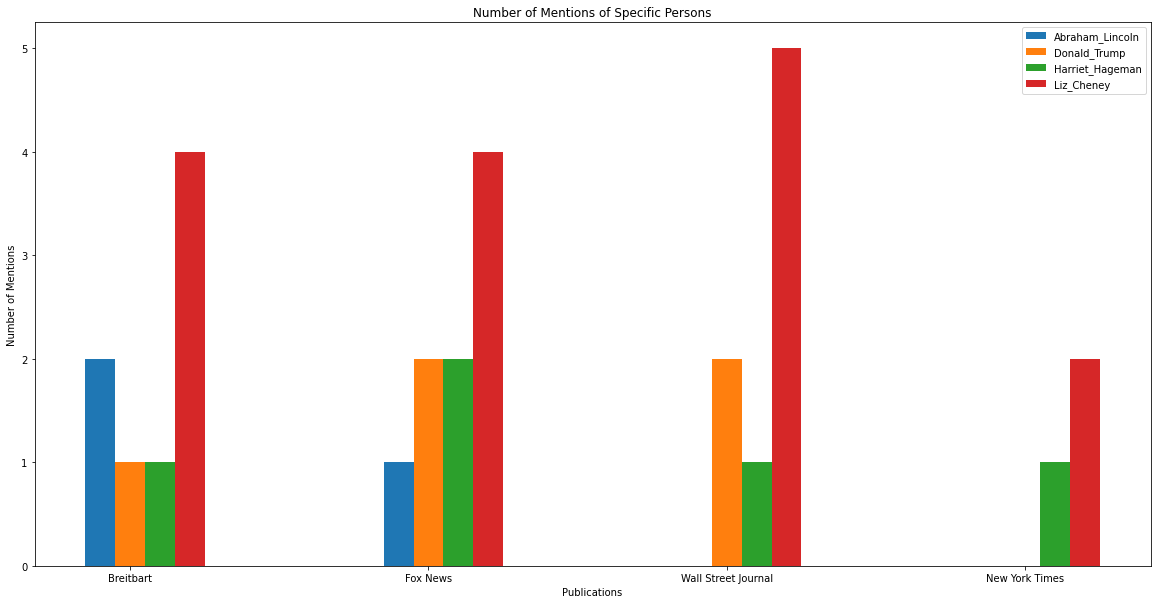

In [12]:
# Display a table of people and counts of their occurrences in the narratives
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy

pubs = list(publisher_dict.keys())
persons = list(person_mentions_dict.keys())
X_axis = np.arange(len(pubs))
start = -0.1
for person, count_array in person_mentions_dict.items():
    plt.bar(X_axis + start, count_array, 0.1, label = person)
    start += 0.1

plt.rcParams['figure.figsize'] = [15, 8]
plt.xticks(X_axis, pubs)
plt.xlabel("Publications")
plt.ylabel("Number of Mentions")
plt.title("Number of Mentions of Specific Persons")
plt.legend()
plt.show()


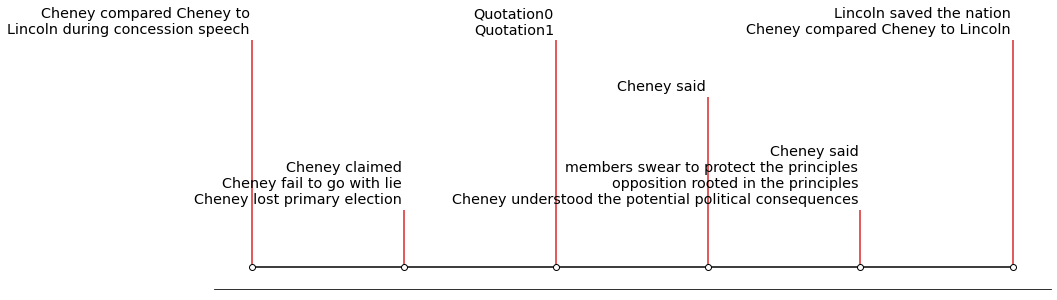

In [40]:
len_arc = len(story_arc_dict)
# For matplotlib timeline, need datetime formatting
title = 'Breitbart Article'
events = []
for key, arc_text in story_arc_dict.items():
    events.append(arc_text)
plot_dates = np.arange(len(events))
# Create a stem plot with some variation in levels as to distinguish close-by events.
# Add markers on the baseline with dates
# For each event, add a text label via annotate, which is offset from the tip of the event line
levels = np.tile([4, 1, 4, 3, 1, 4],
                 int(np.ceil(len(plot_dates) / 6)))[:len(plot_dates)]
# Create figure and plot a stem plot with the dates
fig, ax = plt.subplots()
dpi = fig.get_dpi()
fig.set_size_inches(15, 5)
ax.vlines(plot_dates, 0, levels, color="tab:red")  # The vertical stems
ax.plot(plot_dates, np.zeros_like(plot_dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it
# Annotate lines
for d, l, r in zip(plot_dates, levels, events):
    ax.annotate(r, xy=(d, l),
                xytext=(-2, np.sign(l) * 3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top", fontsize='x-large')
# Format x-axis with yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize='medium')
# Remove x- and y-axis and spines
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.1)
plt.rcParams['figure.figsize'] = [30, 15]
plt.show()

In [46]:
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

In [ ]:
# Eigenvector centrality -- mean and stdev
ec = nx.eigenvector_centrality(G)
degrees = []
for k,v in ec.items():
    degrees.append(v)
    
print("EIGENVECTOR CENTRALITY")
print("======================")
print("The mean network eigenvector centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(ec, key=ec.get), max(ec.values())))
print("The minimum node is {}, with value {}".format(min(ec, key=ec.get), min(ec.values())))
histogram(ec)
print()

# Betweenness centrality -- mean and stdev
bc = nx.betweenness_centrality(G)
degrees = []
for k,v in bc.items():
    degrees.append(v)
print("BETWEENNESS CENTRALITY")
print("======================")
print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
histogram(bc)
print()
    
# Plot
print("Visualizing the graph:")
plt.plot()
nx.draw(G, with_labels=True, font_weight='bold')

In [50]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def number_of_pendants(g):
    """
    Equals the number of nodes with degree 1
    """
    pendants = 0
    for u in g:
        if g.degree[u] == 1:
            pendants += 1
    return pendants


def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)
    
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

LC-Left-Final.ttl
rdflib Graph loaded successfully with 105 triples
networkx Graph loaded successfully with length 93
NETWORK SIZE
The network has 93 nodes and 101 edges

PENDANTS/Nodes with degree 1
The network has 60 pendants

DENSITY
The network density is 0.023609163160355308

DEGREE CENTRALITY
The mean degree centrality is 0.023609163160355297, with stdev 0.02320349485944098
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.10869565217391304
The minimum node is The path was clear, with value 0.010869565217391304
(0.10869565217391304, 0.09782608695652173, 0.08695652173913043, 0.06521739130434782, 0.05434782608695652, 0.043478260869565216, 0.03260869565217391, 0.021739130434782608, 0.010869565217391304) (1, 2, 2, 6, 1, 4, 7, 10, 60)


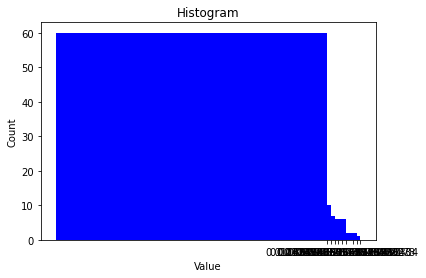


CONNECTED COMPONENTS
The graph has 2 connected components
Connected component 0 has 90 nodes
Connected component 1 has 3 nodes

LC-Center-Final.ttl
rdflib Graph loaded successfully with 116 triples
networkx Graph loaded successfully with length 102
NETWORK SIZE
The network has 102 nodes and 111 edges

PENDANTS/Nodes with degree 1
The network has 66 pendants

DENSITY
The network density is 0.021549213744903904

DEGREE CENTRALITY
The mean degree centrality is 0.021549213744903914, with stdev 0.02110283386856961
The maximum node is urn:ontoinsights:dna:Event_f5bec324-e90a, with value 0.09900990099009901
The minimum node is urn:ontoinsights:dna:PiT_Tuesday, with value 0.009900990099009901
(0.09900990099009901, 0.0891089108910891, 0.07920792079207921, 0.06930693069306931, 0.0594059405940594, 0.04950495049504951, 0.039603960396039604, 0.0297029702970297, 0.019801980198019802, 0.009900990099009901) (1, 2, 1, 4, 3, 4, 1, 10, 10, 66)


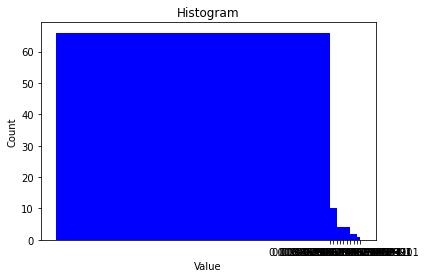


CONNECTED COMPONENTS
The graph has 3 connected components
Connected component 0 has 92 nodes
Connected component 1 has 3 nodes
Connected component 2 has 7 nodes

LC-Right-Final.ttl
rdflib Graph loaded successfully with 138 triples
networkx Graph loaded successfully with length 113
NETWORK SIZE
The network has 113 nodes and 131 edges

PENDANTS/Nodes with degree 1
The network has 74 pendants

DENSITY
The network density is 0.020701643489254108

DEGREE CENTRALITY
The mean degree centrality is 0.020701643489254157, with stdev 0.021879082772030923
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.10714285714285714
The minimum node is urn:ontoinsights:dna:AssessmentAndCharacterization, with value 0.008928571428571428
(0.10714285714285714, 0.09821428571428571, 0.08035714285714285, 0.07142857142857142, 0.0625, 0.05357142857142857, 0.04464285714285714, 0.03571428571428571, 0.026785714285714284, 0.017857142857142856, 0.008928571428571428) (1, 1, 2, 5, 2, 4, 1, 5, 8, 10, 74)


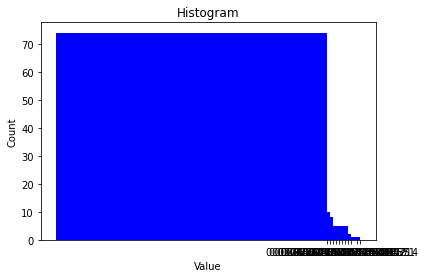


CONNECTED COMPONENTS
The graph has 6 connected components
Connected component 0 has 99 nodes
Connected component 1 has 4 nodes
Connected component 2 has 3 nodes
Connected component 3 has 3 nodes
Connected component 4 has 2 nodes
Connected component 5 has 2 nodes

LC-FarRight-Final.ttl
rdflib Graph loaded successfully with 104 triples
networkx Graph loaded successfully with length 82
NETWORK SIZE
The network has 82 nodes and 98 edges

PENDANTS/Nodes with degree 1
The network has 52 pendants

DENSITY
The network density is 0.029509183980728697

DEGREE CENTRALITY
The mean degree centrality is 0.02950918398072873, with stdev 0.03381037376815727
The maximum node is urn:ontoinsights:dna:Event_23f401c8-fd1c, with value 0.18518518518518517
The minimum node is From Wikipedia (wikibase_item: Q91): 'Abraham Lincoln was an American lawyer and statesman who served as the 16th president of the United States from 1861 until his assassination in 1865. Lincoln led the nation through the American Civil

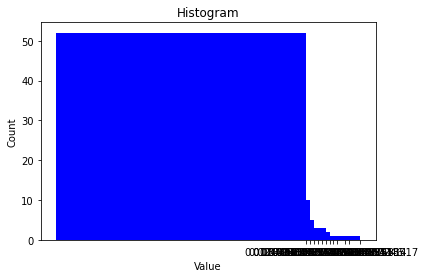


CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 82 nodes



In [57]:
for i in range(4):
    # For matplotlib timeline, need datetime formatting
    if i == 0:
        title = 'LC-Left-Final.ttl'
    elif i == 1:
        title = 'LC-Center-Final.ttl'
    elif i == 2:
        title = 'LC-Right-Final.ttl'
    elif i == 3:
        title = 'LC-FarRight-Final.ttl'
    print(title)
    rg = RDFGraph()
    rg.parse(title, format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(rg)))
    G = rdflib_to_networkx_graph(rg)
    print("networkx Graph loaded successfully with length {}".format(len(G)))
    
    # Network size
    print("NETWORK SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
    print()

    # Network size
    print("PENDANTS/Nodes with degree 1")
    print("============")
    print("The network has {} pendants".format(number_of_pendants(G)))
    print()

    # Density
    print("DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(G)))
    print()

    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(G)
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print("DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()

    # Connected components
    cc = list(nx.connected_components(G))
    print("CONNECTED COMPONENTS")
    print("====================")
    print("The graph has {} connected components".format(len(cc)))
    for i,c in enumerate(cc):
        print("Connected component {} has {} nodes".format(i,len(c)))
    print()